# Solar Radiation Forecasting Using Gradient-Boosting Regression Algorithm

**Solar Radiation Prediction**

Understanding solar radiation as a function of meteorological factors is crucial for optimizing various sectors. Insights into this information can enhance the performance of photovoltaic panels and solar energy plants, assist authorities in warning about hazardous radiation zones, guide farmers in making informed cropping decisions, and support research efforts in understanding ecosystems and meteorological phenomena.

For this project, I have implemented a machine learning algorithm using **XGBoost** to predict solar radiation at the HI-SEAS NASA facility in Hawaii.

The data used in this analysis was provided by NASA's HI-SEAS project, which offers valuable information about solar radiation along with other meteorological variables at the research facility.

In [1]:
import xgboost as xgb
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

First, I create a DataFrame containing the HI-SEAS meteorological data, which is named `DF_Sun`.

In [2]:
file_path = r"C:\Users\Dell\Desktop\jp\files\SolarPrediction.csv"
DF_Sun = pd.read_csv(file_path, index_col=0)
print(DF_Sun.head(3))

                        Data      Time  Radiation  Temperature  Pressure  \
Index                                                                      
1      9/29/2016 12:00:00 AM  23:55:26       1.21           48     30.46   
2      9/29/2016 12:00:00 AM  23:50:23       1.21           48     30.46   
3      9/29/2016 12:00:00 AM  23:45:26       1.23           48     30.46   

       Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  \
Index                                                                   
1            59                  177.39   5.62    06:13:00   18:13:00   
2            58                  176.78   3.37    06:13:00   18:13:00   
3            57                  158.75   3.37    06:13:00   18:13:00   

             UNIX  Index.1  
Index                       
1      1475229326        1  
2      1475229023        2  
3      1475228726        3  


# HI-SEAS Meteorological Data (September - December 2016) #

This dataset contains meteorological data from the HI-SEAS weather station, collected between September and December 2016, during Mission IV and Mission V. The data includes several weather parameters recorded at different times, organized by the following fields:

**Fields in the Dataset:**
- **Row Number (1-n):** Useful for sorting the dataset results.
- **UNIX Time (time_t):** Time in seconds since January 1, 1970, for accurate sorting across different datasets.
- **Date (yyyy-mm-dd):** The recorded date in the format yyyy-mm-dd.
- **Local Time (hh:mm:ss):** The local time in 24-hour format corresponding to the recorded data.
- **Numeric Data:** The recorded meteorological data, or an empty string if not available.
- **Text Data:** Any text-related information, or an empty string if not available.

**Units of Measurement:**
- **Solar Radiation:** Watts per meter² (W/m²)
- **Temperature:** Degrees Fahrenheit (°F)
- **Humidity:** Percentage (%)
- **Barometric Pressure:** Inches of mercury (Hg)
- **Wind Direction:** Degrees (°)
- **Wind Speed:** Miles per hour (mph)
- **Sunrise/Sunset:** Hawaii Standard Time (HST)

These data points are crucial for analyzing the environmental conditions in the HI-SEAS habitat, particularly for studying solar radiation and other meteorological variables during the mentioned mission periods. The dataset is available at: https://www.kaggle.com/datasets/dronio/SolarEnergy/data


### Converting UNIX Timestamps to Datetime and Extracting Date Components

In this step, the UNIX timestamps from the "UNIX" column are converted into datetime objects using the `fromtimestamp()` function. The resulting datetime is stored in a new column, "Datetime". The year, month, and day are extracted from the "Datetime" column using the `apply()` function to create the "Year", "Month", and "Day" feeatures, respectively.

In [3]:
DF_Sun["Datetime"] = DF_Sun["UNIX"].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=datetime.timezone.utc))
DF_Sun["Year"] = DF_Sun["Datetime"].apply(lambda x: x.year)
DF_Sun["Month"] = DF_Sun["Datetime"].apply(lambda x: x.month)
DF_Sun["Day"] = DF_Sun["Datetime"].apply(lambda x: x.day)

### Extracting Time Components from the "Time" Feature

Nxt, the "Time" column, which contains time values in the format "HH:MM:SS", is split into separate columns for hours, minutes, and seconds using the `str.split()` method. I convert these components to integers to ensure correct numerical operations can be performed.

In [4]:
DF_Sun[["hours", "minutes", "seconds"]] = DF_Sun["Time"].str.split(':', expand=True)
DF_Sun["hours"] = DF_Sun["hours"].astype(int)
DF_Sun["minutes"] = DF_Sun["minutes"].astype(int)
DF_Sun["seconds"] = DF_Sun["seconds"].astype(int)

### Extracting Time Components from the "TimeSunRise" Feature

Similar to the previous step, the "TimeSunRise" column, which contains the sunrise time in the format "HH:MM:SS", is split into separate columns for hours, minutes, and seconds. 

In [5]:
DF_Sun[["hours_sr", "minutes_sr", "seconds_sr"]] = DF_Sun["TimeSunRise"].str.split(':', expand=True)
DF_Sun["hours_sr"] = DF_Sun["hours_sr"].astype(int)
DF_Sun["minutes_sr"] = DF_Sun["minutes_sr"].astype(int)
DF_Sun["seconds_sr"] = DF_Sun["seconds_sr"].astype(int)

### Extracting Time Components from the "TimeSunRise" Feature

Finally, "TimeSunRise" column, which contains the sunrise time in the format "HH:MM:SS", is split into separate columns for hours, minutes, and seconds.

In [6]:
DF_Sun[["hours_ss", "minutes_ss", "seconds_ss"]] = DF_Sun["TimeSunSet"].str.split(':', expand=True)
DF_Sun["hours_ss"] = DF_Sun["hours_ss"].astype(int)
DF_Sun["minutes_ss"] = DF_Sun["minutes_ss"].astype(int)
DF_Sun["seconds_ss"] = DF_Sun["seconds_ss"].astype(int)

### Feature Engineering

This code cell introduces new features to the dataset `DF_Sun` for enhanced meteorological analysis:

- **HOUR**: Converts hours, minutes, and seconds into a fractional hour value.
- **Hot_time**: Identifies hours between 10 a.m. and 3 p.m. as hot.
- **Sunlight_hours**: Calculates the duration of sunlight in hours.
- **Sun_presence**: Indicates whether the current time is during daylight hours.
- **High_temperature**: Flags temperatures above 60°F.
- **High_pressure**: Flags pressure values above 30.45 Hg.
- **South_wind**: Identifies wind directions between 255°–320° as southern.
- **Meteorological_Indicators**: Computes the euclidean norm various meteorological indicators.


In [7]:
DF_Sun["HOUR"] = DF_Sun["hours"] + (1 / 60) * DF_Sun["minutes"] + (1 / 3600) * DF_Sun["seconds"]
DF_Sun["Hot_time"] = np.where((DF_Sun["hours"] > 10) & (DF_Sun["hours"] < 15), 1, 0)
DF_Sun["Sunlight_hours"] = (DF_Sun["hours_ss"] - DF_Sun["hours_sr"]) + (1 / 60) * (DF_Sun["minutes_ss"] - DF_Sun["minutes_sr"]) + (1 / 3600) * (DF_Sun["seconds_ss"] - DF_Sun["seconds_sr"])
DF_Sun["Sun_presence"] = np.where((DF_Sun["hours"] > DF_Sun["hours_sr"]) & (DF_Sun["hours"] < DF_Sun["hours_ss"]), 1, 0)
DF_Sun["High_temperature"] = np.where((DF_Sun["Temperature"] > 60), 1, 0)
DF_Sun["High_pressure"] = np.where((DF_Sun["Pressure"] > 30.45), 1, 0)
DF_Sun["South_wind"] = np.where((DF_Sun["WindDirection(Degrees)"] > 255) & (DF_Sun["WindDirection(Degrees)"] < 320), 1, 0)
DF_Sun["Meteorological_Indicators"] = np.sqrt(
    DF_Sun["Hot_time"]**2
    + DF_Sun["Sun_presence"]**2
    + DF_Sun["South_wind"]**2
    + DF_Sun["High_pressure"]**2
    + DF_Sun["High_temperature"]**2
) 

### Exploring Relationships through Graphical Visualization 

To better understand the interactions between the meteorological variables provided by the HI-SEAS facility and solar radiation, a series of barplots and scatterplots are presented. These visualizations highlight how solar radiation behaves in relation to key features such as **daytime**, **temperature**, **wind speed**, **relative humidity**, **wind direction**, **barometric pressure**, and the **month of the year**. 

Text(0.5, 1.0, 'Radiation vs Daytime')

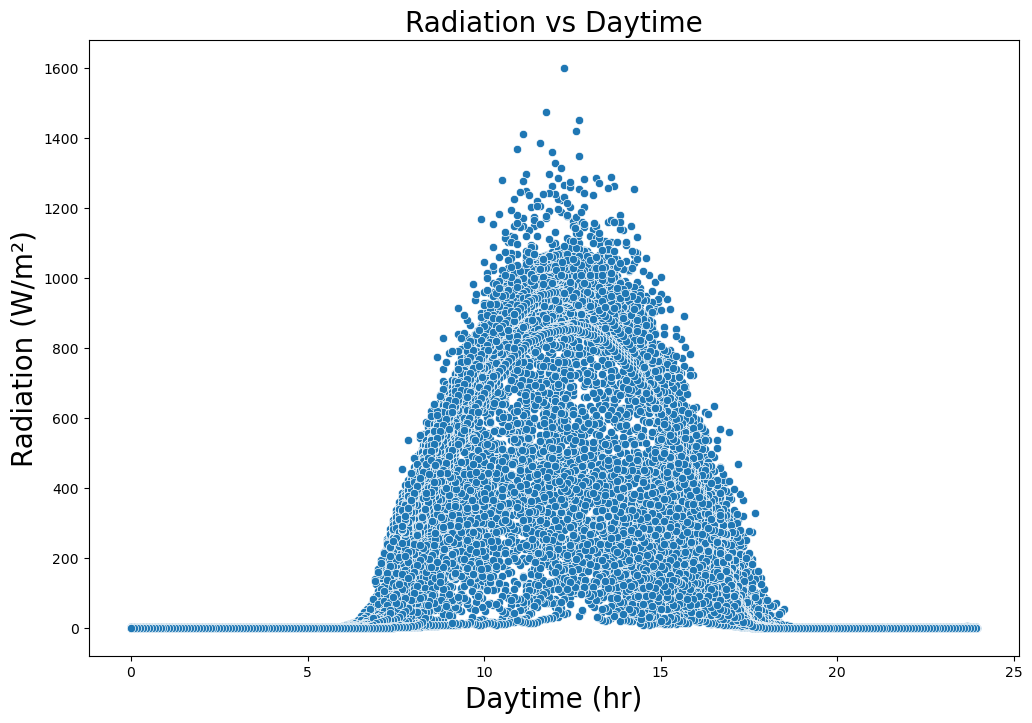

In [8]:
fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data = DF_Sun, ax=ax2, x="HOUR", y = "Radiation")
ax2.set_xlabel("Daytime (hr)", fontsize=20)
ax2.set_ylabel("Radiation (W/m²)", fontsize=20)
ax2.set_title("Radiation vs Daytime", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Hour of the Day')

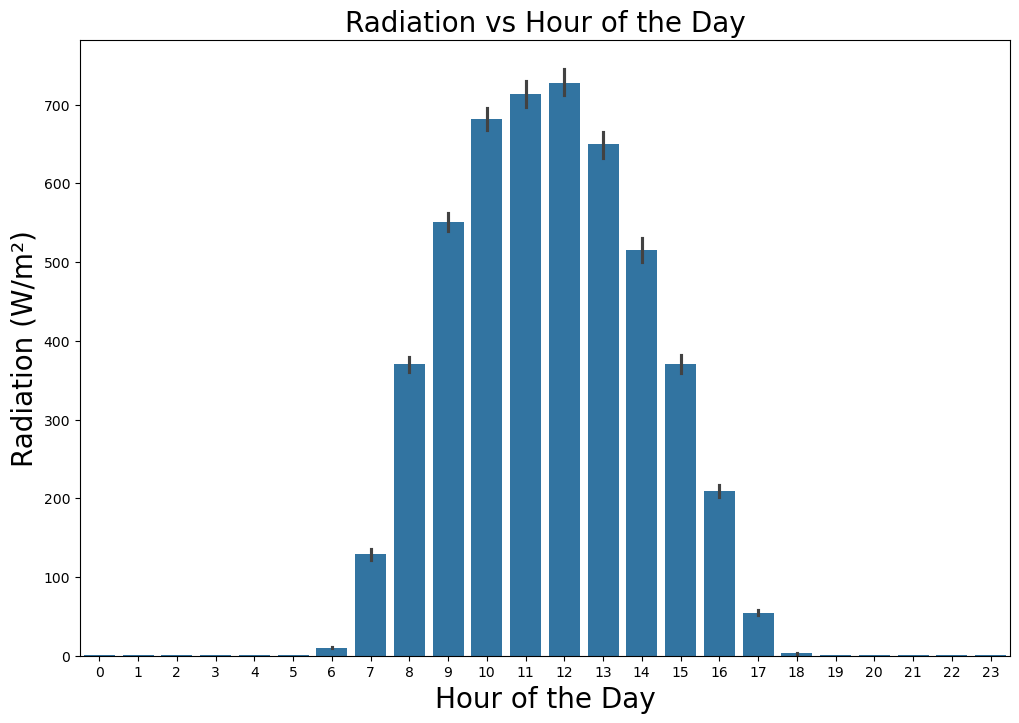

In [9]:
fig, ax21 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data = DF_Sun, ax=ax21, x="hours", y = "Radiation")
ax21.set_xlabel("Hour of the Day", fontsize=20)
ax21.set_ylabel("Radiation (W/m²)", fontsize=20)
ax21.set_title("Radiation vs Hour of the Day", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Temperature')

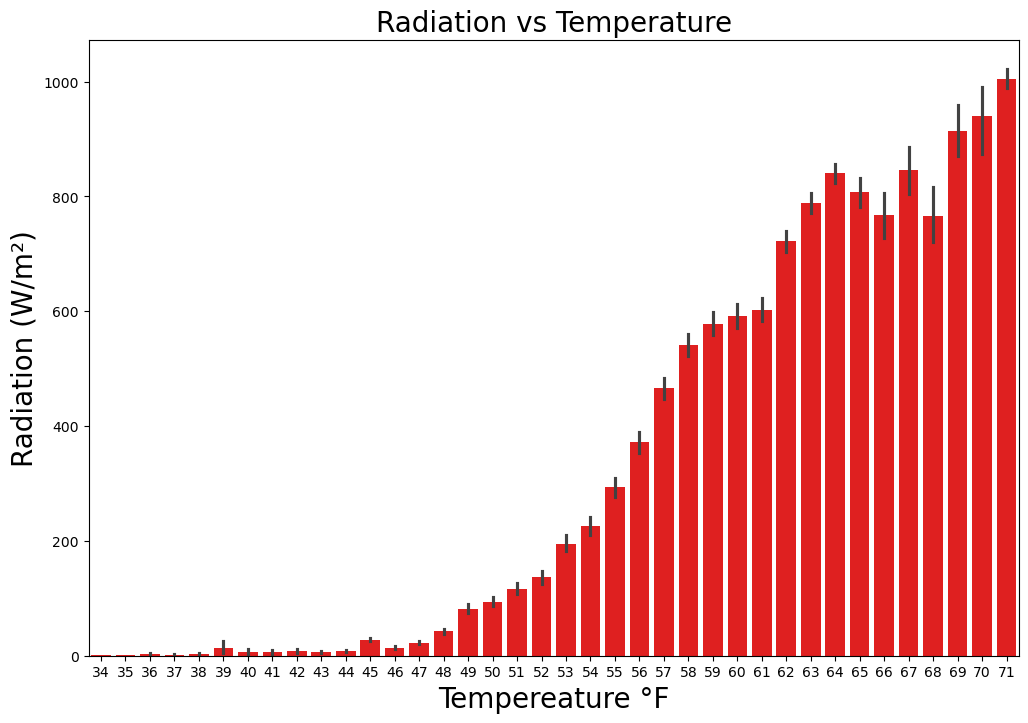

In [10]:
fig, ax31 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data = DF_Sun, ax=ax31, x="Temperature", y = "Radiation",color="red")
ax31.set_xlabel("Tempereature °F", fontsize=20)
ax31.set_ylabel("Radiation (W/m²)", fontsize=20)
ax31.set_title("Radiation vs Temperature", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Wind Speed')

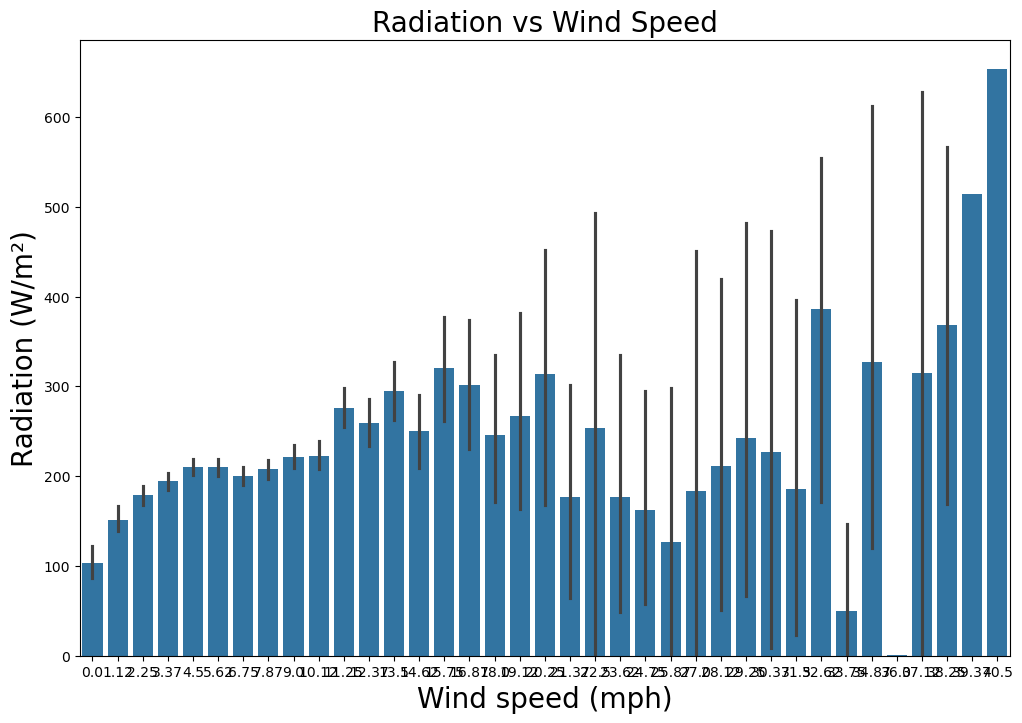

In [11]:
fig, ax4 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data = DF_Sun, ax=ax4, x="Speed", y = "Radiation")
ax4.set_xlabel("Wind speed (mph)", fontsize=20)
ax4.set_ylabel("Radiation (W/m²)", fontsize=20)
ax4.set_title("Radiation vs Wind Speed", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Humidity')

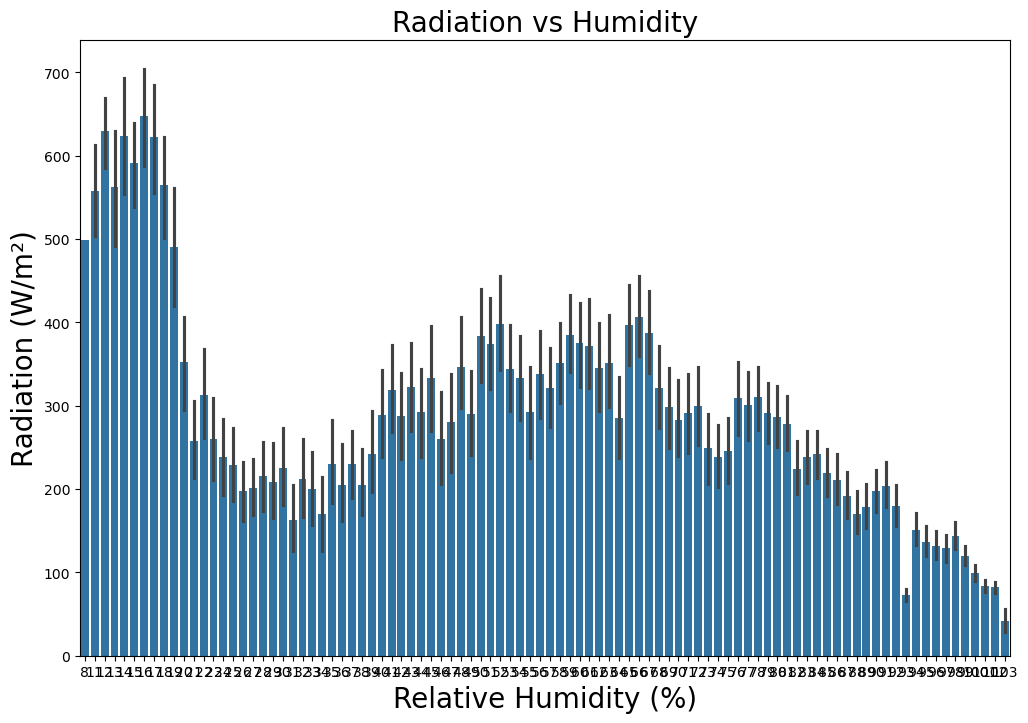

In [12]:
fig, ax51 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data = DF_Sun, ax=ax51, x="Humidity", y = "Radiation")
ax51.set_xlabel("Relative Humidity (%)", fontsize=20)
ax51.set_ylabel("Radiation (W/m²)", fontsize=20)
ax51.set_title("Radiation vs Humidity", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Wind Direction')

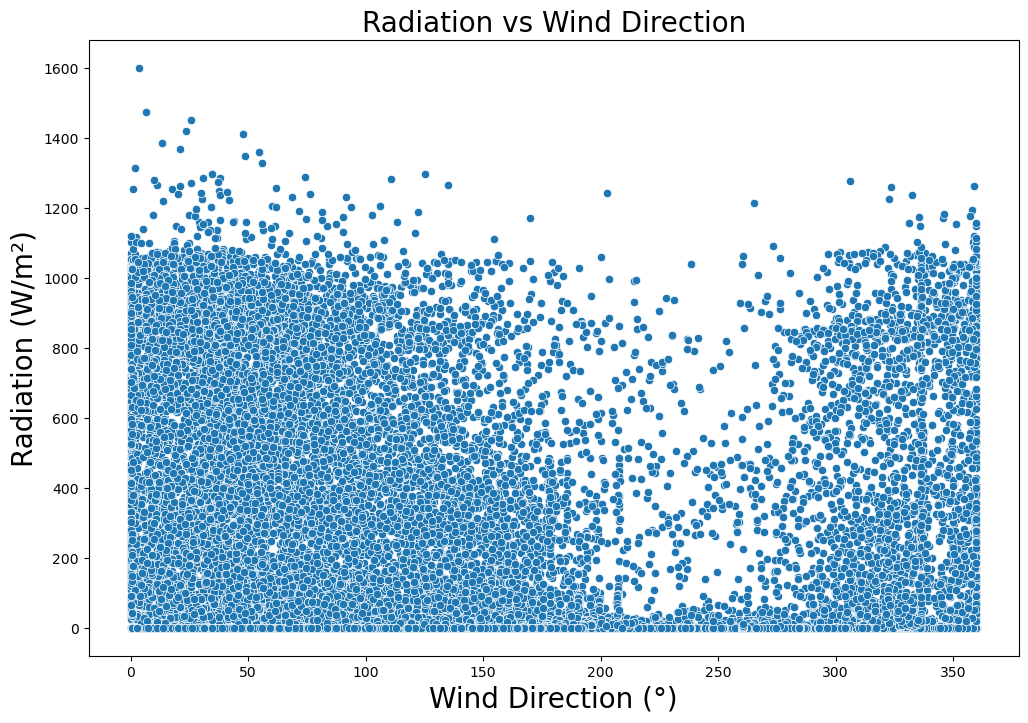

In [13]:
fig, ax6 = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(data = DF_Sun, ax=ax6, x="WindDirection(Degrees)", y = "Radiation")
ax6.set_xlabel("Wind Direction (°)", fontsize=20)
ax6.set_ylabel("Radiation (W/m²)", fontsize=20)
ax6.set_title("Radiation vs Wind Direction", fontsize=20)

Text(0.5, 1.0, 'Radiation vs Pressure')

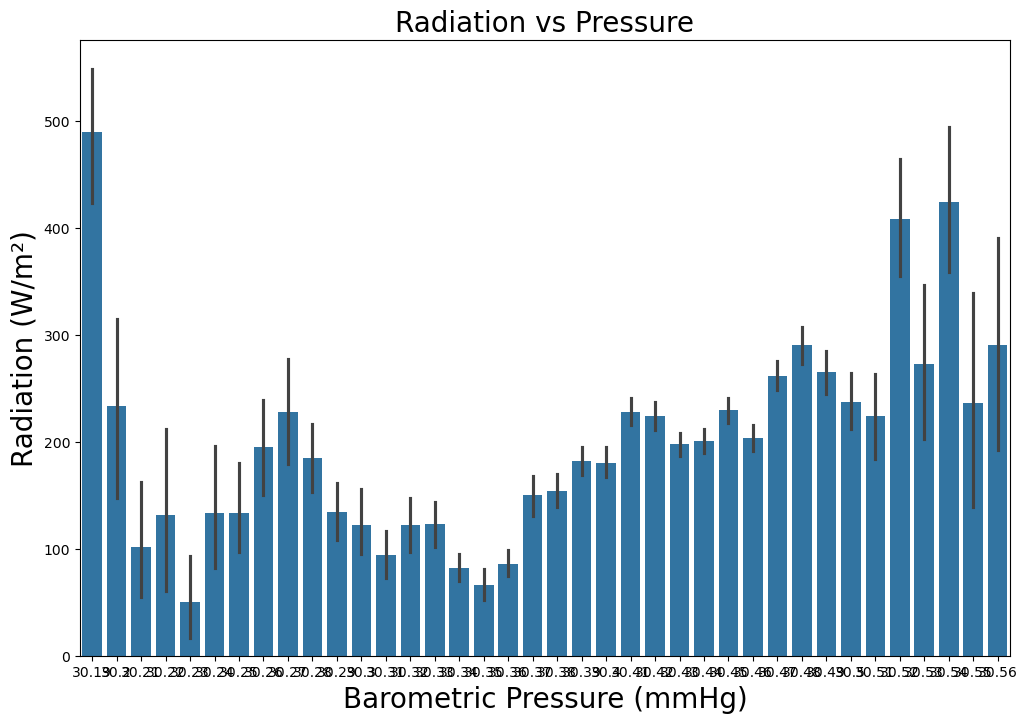

In [14]:
fig, ax7 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data = DF_Sun, ax=ax7, x="Pressure", y = "Radiation")
ax7.set_xlabel("Barometric Pressure (mmHg)", fontsize=20)
ax7.set_ylabel("Radiation (W/m²)", fontsize=20)
ax7.set_title("Radiation vs Pressure", fontsize=20)

Text(0.5, 1.0, 'Average Solar Radiation per Month')

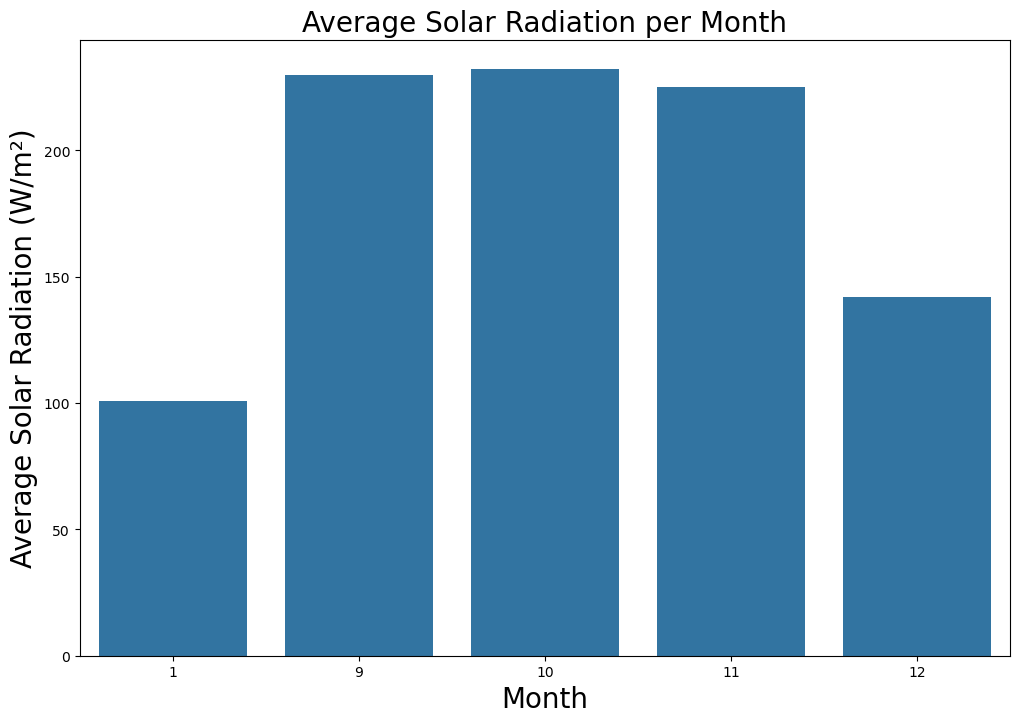

In [15]:
DF_Sun = DF_Sun.dropna(subset=["Radiation"])
monthly_avg_radiation = DF_Sun.groupby("Month")["Radiation"].mean().reset_index()
fig, ax8 = plt.subplots(1, 1, figsize=(12, 8))
sns.barplot(data=monthly_avg_radiation, ax=ax8, x="Month", y="Radiation")
ax8.set_xlabel("Month", fontsize=20)
ax8.set_ylabel("Average Solar Radiation (W/m²)", fontsize=20)
ax8.set_title("Average Solar Radiation per Month", fontsize=20)

### Feature Scaling Process ###

In [16]:
scaler = MinMaxScaler()
DF_Sun["Temperature_log"] = np.log(DF_Sun["Temperature"])
DF_Sun["Temperature_log_scaled"] = scaler.fit_transform(DF_Sun[["Temperature_log"]])
DF_Sun["Speed"] = DF_Sun["Speed"].replace(0, 0.0001)
DF_Sun["Speed_scaled"] = np.log(DF_Sun["Speed"])
DF_Sun["Humidity_scaled"] = scaler.fit_transform(DF_Sun[["Humidity"]])
DF_Sun["Humidity_log"] = np.log(DF_Sun["Humidity"])
DF_Sun["Daylight_scaled"] = scaler.fit_transform(DF_Sun[["HOUR"]])
DF_Sun["Sunlight_scaled"] = scaler.fit_transform(DF_Sun[["Sunlight_hours"]])
DF_Sun["UNIX_scaled"] = scaler.fit_transform(DF_Sun[["UNIX"]])

In [17]:
scaler = StandardScaler()
DF_Sun["Pressure_scaled"] = scaler.fit_transform(DF_Sun[["Pressure"]])
DF_Sun["Temperature_std_scaled"] = scaler.fit_transform(DF_Sun[["Temperature"]])
DF_Sun["Radiation_scaled"] = np.log(DF_Sun["Radiation"])

### Clustering Solar Radiation Data

I perform clustering on the HI-SEAS dataset using the KMeans algorithm. The goal is to group the data based on selected features: **Temperature**, **Pressure**, **Humidity**, **Hour of the day**, and **Wind Speed**. The cluster a data point is assigned to will later participate as a feature for the XGBoost algorithm.


In [18]:
def cluster(K):
    features = ["Temperature_log", "Pressure_scaled", "Humidity_scaled", "HOUR", "Speed_scaled"]
    X_cluster = DF_Sun[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    DF_Sun["Cluster"] = kmeans.fit_predict(X_scaled)

cluster(10)

### Feature Engineering ###

I ngineer new features by combining existing ones to capture more intricate and deeper relationships within the meteorological data. Additionally, I apply power transformations to certain features to increase their significance.

In [19]:
DF_Sun["T&H"] = DF_Sun["Temperature"] * DF_Sun["Humidity"]
DF_Sun["T&P"] = DF_Sun["Temperature"] * DF_Sun["Pressure"]
DF_Sun["T&WindSpeed"] = DF_Sun["Temperature"] * DF_Sun["Speed"]
DF_Sun["H&WindSpeed"] = DF_Sun["Humidity"] * DF_Sun["Speed"]
DF_Sun["H&Pressure"] = DF_Sun["Humidity"] * DF_Sun["Pressure"]
DF_Sun["WindSpeed^2"] = DF_Sun["Speed"] ** 2
DF_Sun["Pressure^2"] = DF_Sun["Pressure"] ** 2
DF_Sun["T^2"] = DF_Sun["Temperature"] ** 2
DF_Sun["H^2"] = DF_Sun["Humidity"] ** 2
DF_Sun["P^2"] = DF_Sun["Pressure"] ** 2
DF_Sun["WindDirection^2"] = DF_Sun["WindDirection(Degrees)"] ** 2
DF_Sun["T&WindDirection"] = DF_Sun["Temperature"] * DF_Sun["WindDirection(Degrees)"]
DF_Sun["H&WindDirection"] = DF_Sun["Humidity"] * DF_Sun["WindDirection(Degrees)"]
DF_Sun["WindSpeed&WindDirection"] = DF_Sun["Speed"] * DF_Sun["WindDirection(Degrees)"]

### Selecting Features with Random Forest Algorithm, ###
To select relevant features for the model, I use the **Random Forest** algorithm, which is capable of assigning a numerical value to each feature hat represents its correlation with the target feature. I collect the importance of each feature using a DataFrame and graph the results. The most relevant features will be later incorporated into the feature vector.

Text(0, 0.5, 'Feature')

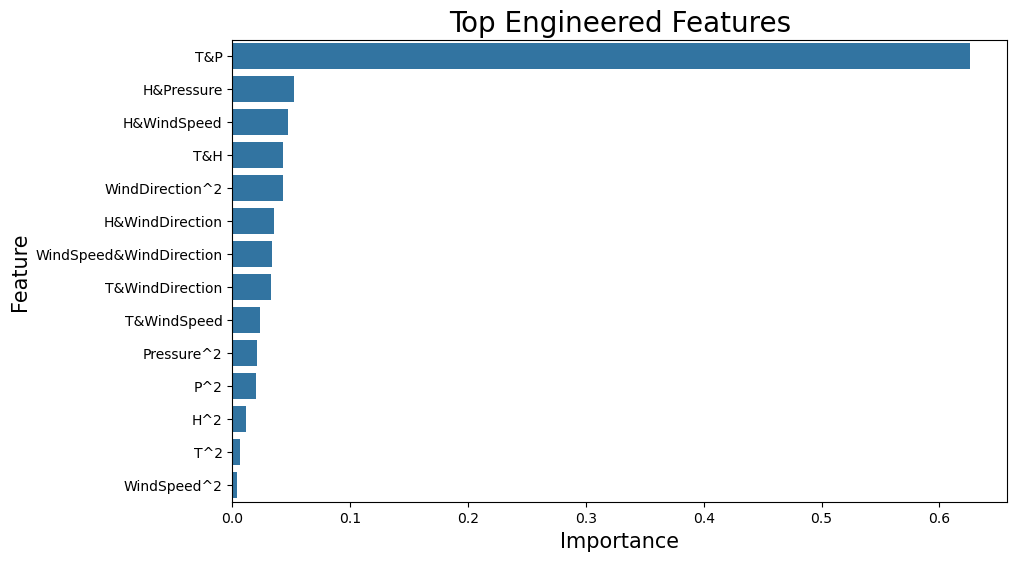

In [20]:
from sklearn.ensemble import RandomForestRegressor

X = DF_Sun[[
    "T&H", 
    "T&P", 
    "T&WindSpeed", 
    "H&WindSpeed", 
    "H&Pressure", 
    "WindSpeed^2", 
    "Pressure^2", 
    "T^2", 
    "H^2", 
    "P^2", 
    "WindDirection^2", 
    "T&WindDirection", 
    "H&WindDirection", 
    "WindSpeed&WindDirection"
]]
y = DF_Sun["Radiation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RandomForestRegressor()
model.fit(X_train, y_train)

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

top_features = importance_df.head(14)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features, legend=False)
plt.title("Top Engineered Features", fontsize=20)
plt.xlabel("Importance", fontsize=15)
plt.ylabel("Feature", fontsize=15)

### Feature Vector ###

In [21]:
Features = ["HOUR",
            "Humidity_log",
            "UNIX_scaled",
            "Humidity_scaled",
            "Sunlight_hours",
            "Meteorological_Indicators",
            "Cluster",
            "Temperature_log",
            "T&P",
            "H&Pressure",
            "H&WindSpeed",
            "WindDirection^2"
           ]

### Data Preparation for Model Training

I use the hold-out method for model training. The dataset is split into features (`X`) and target variable (`Y`), where `X` consists of the selected features and `Y` contains the solar radiation values. The data is then divided into training and testing sets using `train_test_split`, with 70% allocated for training and 30% for testing. 

In [22]:
X = DF_Sun[Features]
Y = DF_Sun["Radiation"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
dtrain = xgb.DMatrix(X_train, label = Y_train)
dtest = xgb.DMatrix(X_test, label = Y_test)

### Model Hyperparameters

I present this **XGBoost** hyperparameters dictionary:
- `learning_rate`: Controls the step size at each iteration (0.01).
- `max_depth`: Maximum depth of each tree (5).
- `eval_metric`: The evaluation metric to be optimized (root mean square error - `rmse`).
- `gamma`: Minimum loss reduction required to make a further partition (5).
- `lambda`: L2 regularization term on weights (2000).
- `alpha`: L1 regularization term on weights (10).
- `colsample_bytree`: Fraction of features to sample for building each tree (0.5).
- `subsample`: Fraction of training data to sample for each tree (0.7).
- `min_child_weight`: Minimum sum of instance weight needed in a child (5).
- `colsample_bylevel`: Fraction of features to sample for each level (0.7).
- `colsample_bynode`: Fraction of features to sample for each split (0.8)


In [23]:
params = {
    "learning_rate": 0.01,
    "max_depth": 5,
    "eval_metric": "rmse",
    "gamma": 5,
    "lambda": 2000,
    "alpha": 10,
    "colsample_bytree": 0.5,
    "subsample": 0.7,
    "min_child_weight": 5,
    "colsample_bylevel": 0.7,
    "colsample_bynode": 0.8
}

### Training the Model

In [24]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round = 15000, verbose_eval=False, evals=[(dtrain, "train"), (dtest, "eval")], evals_result = evals_result)

### Learning Curve

I plot the learning history of the model 

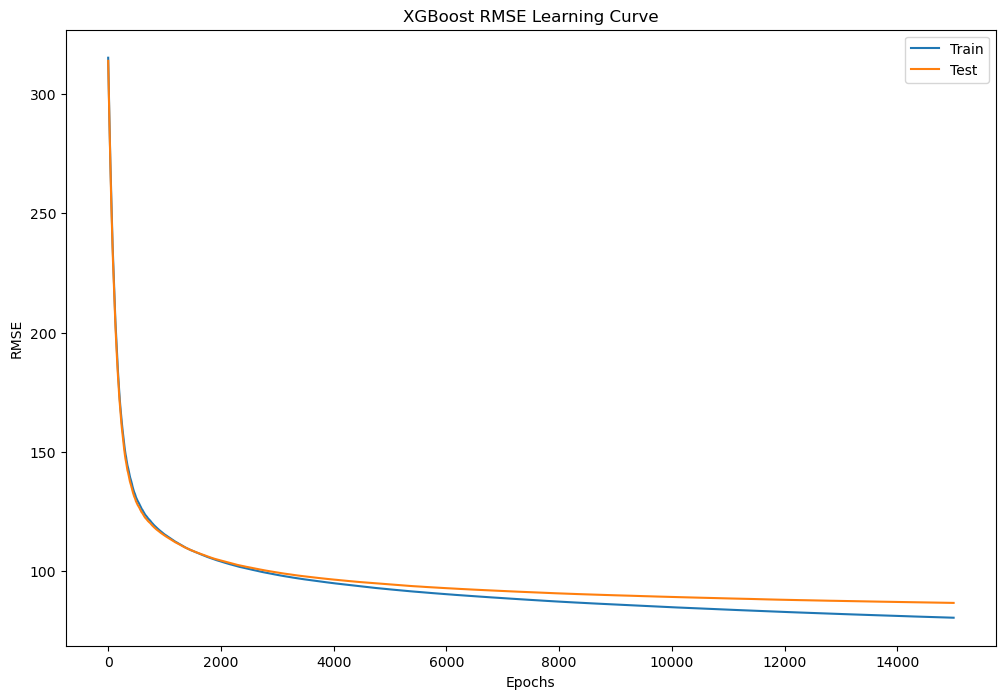

In [25]:
epochs = len(evals_result["train"]["rmse"])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, evals_result["train"]["rmse"], label="Train")
ax.plot(x_axis, evals_result["eval"]["rmse"], label="Test")
ax.legend()
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.title("XGBoost RMSE Learning Curve")
plt.show()

### Performance Metrics

In [26]:
Y_pred = abs(model.predict(dtest))
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean SAboslute Error: {mae}")
r2_test = r2_score(Y_test, Y_pred)
print(f"R^2 Score: {r2_test}")

Mean Squared Error: 7510.682641120914
Mean SAboslute Error: 41.53766894510967
R^2 Score: 0.9243074191467209


### Predicted vs Real Data Comparison

I create a DataFrame to compare the predicted and actual solar radiation values. Subsequently, I visualize the results using a scatter plot to evaluate the performance of the algorithm.

Text(0.5, 1.0, 'Algorithm Performance')

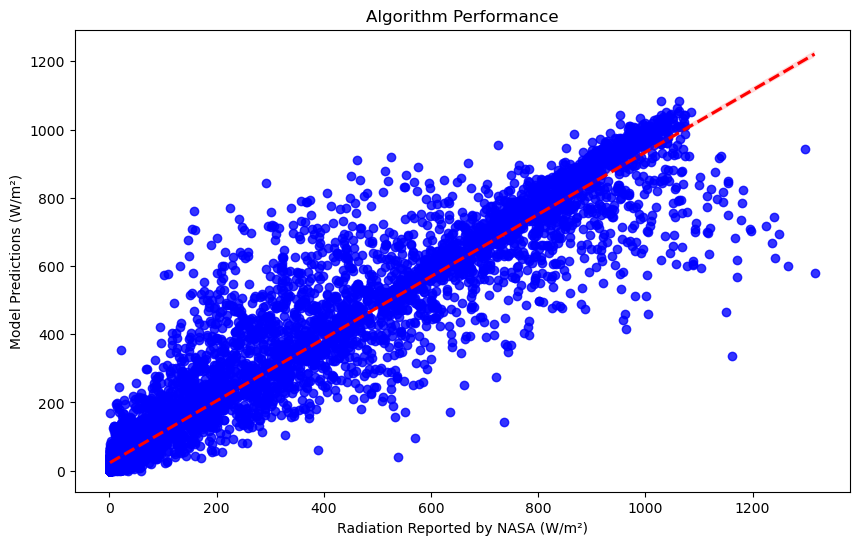

In [27]:
compa_df = pd.DataFrame({
    "Actual radiation": Y_test.values,       
    "Predicted radiation": Y_pred.squeeze()
})

plt.figure(figsize=(10, 6))
sns.regplot(x="Actual radiation", y="Predicted radiation", data=compa_df, scatter_kws={"color": "blue"}, line_kws={"color": "red", "linestyle": "--"})
plt.xlabel("Radiation Reported by NASA (W/m²)")
plt.ylabel("Model Predictions (W/m²)")
plt.title("Algorithm Performance")

### Conclusion

The **XGBoost Algorithm** demonstrated an overall strong performance. The R² coefficient was 0.92, and the MAE was 41 W/m². Although there is room for improvement, the predictions were solid, and the selected features are easy to compute and can be instrumentalized, making them suitable for implementation in photovoltaic technologies or smart farming systems. Further hyperparameter tuning and advanced feature engineering could enhance the performance and generalizability of the algorithm.